# Facebook Conversation Analysis

Here is some analysis I performed on my message history with my girlfriend of around 5 months. Seeing as we often have questions regarding our history of talking to each other, I thought it'd be interesting to analyze our Facebook Messenger message history and try to answer some of these questions, as well as uncovering some interesting information.

I started by importing the necessary packages to not only find the data in my file directory, but also plotting libraries, NLP libraries, and even a wordcloud library as part of my analysis.

In [1]:
# program for analyzing some of my facebook conversations
import numpy as np
import pandas as pd
import sys
import os
import json
import re
import glob
from datetime import datetime

# nlp libraries
from nltk.tokenize import word_tokenize
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk import ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

path = 'D:\\Python\\fb convo analysis'

## Functions

Below are some functions I built to make my code look a little cleaner and more understandable. 

### get_message

The purpose of get_message is to successfully retrieve any json message files from my file directory (whose contents aren't in the repo for obvious reasons) based on a query, which could be the name of any person I talked to on Facebook. Since the json files containing the messages have a max of 10,000 messages, the file folder containing the messages will typically contain multiple json files. I took this into account as I built this function and added the functionality of being able to detect all json files within the directory and append them all onto a list, which is the output of this function.

In [2]:
# function that gets all json files from directory depending on the query
def get_message(query):
    message_list = []
    message_path = os.path.join(path, 'facebook-shawnliu90\messages\inbox')
    # searching through message_path for query
    message_folder = os.listdir(message_path)
    # combining message path with the file name to get that specific person's messages
    message_file = os.path.join(message_path, list(filter(lambda x: query in x, message_folder))[0])
    # changing file path to message_file and finding all json files containing messages
    os.chdir(message_file)
    read_files = glob.glob('*.json')
    # appends each json to a list of jsons
    for file in read_files:
        with open(file, "r", encoding = 'utf-8') as infile:
            message_list.append(json.load(infile))
    return message_list

### format_message

This function formats all text within each json in the output of get_message and appends them onto a string, effectively cleaning the data to enter into the wordcloud.

In [3]:
# function that formats the message into one big string for word cloud
def format_message(text):
    message_string = ''
    for content in text['messages']:
        if 'content' in content.keys():
            # Appends all text into one big string
            message_string = message_string + ' ' + content['content']
    # Removing leading and trailing spaces
    message_string = message_string.rstrip().lstrip()
    message_string.replace('â\x80\x99', '\'')
    return message_string

### create_wordcloud

Here is the function that creates the wordcloud of all the unique words used in our conversation. I added some junk words into the stopwords to exclude from the wordcloud as I'm guilty of overusing these words in all my conversations. 

In [4]:
# removing junk words by adding to stopwords
junk_words = {'lol', 'yeah', 'okay', 'thank', 'thanks', 'you', 'man'
              'go', 'think', 'oh', 'ok','that', 'thats', 'yo', 'ya', 'bro', 'im', 'ye'}

for word in junk_words:
    STOPWORDS.add(word)

# wordcloud function
def create_wordcloud(text):
    # mask image for the shape of the cloud
    mask = np.array(Image.open(os.path.join(path, 'mask.png')))
    # filtering out stopwords like the, and, is, etc.
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color = 'white', mask = mask, max_words = 200, stopwords = stopwords)
    # generating the wordcloud
    wc.generate(text)
    return wc

### date_conversion

This is the function that converts timestamps into datetime objects. Seeing as I'll be needing correct dates in any analysis I perform, I thought it would be the easiest if I made the process into a function to increase readibility and save some lines of code.

In [5]:
# function that converts the date in text for purposes of plotting 
def date_conversion(text):
    # converting timestamps into dates, first by dividing out the milliseconds in the timestamps
    text['timestamp_ms'] = text['timestamp_ms']//1000
    # iterating and appending onto a list, then replacing the timestamp column with the date list
    date_list = []
    for timestamp in text['timestamp_ms']:
        timestamp = datetime.fromtimestamp(timestamp)
        date_list.append(timestamp)
    text['timestamp_ms'] = date_list
    return text

### cleaner

Data cleaning function (tokenization, stemming, substitutions, and conversions) that prepares the actual text for sentiment analysis. Also tokenizes, lemmatizes, position tag, and identifies named entities for each message depending on the purpose.

In [6]:
# internet slang that might get lost in translation if not mapped correctly
internet_slang = {'lol': 'laugh out loud','lmao': 'laughing my ass off', 'idk': 'i don\'t know', 'idc': 'i don\'t care', 
                  'wtf': 'what the fuck', 'omg' : 'oh my god', 'kk': 'okay', 'okie': 'okay', 'u': 'you', 
                  'ur': 'your', 'jk': 'just kidding'}

# function that cleans text by replacing odd strings, internet slang, and tokenization/lemmatization if need be
def cleaner(df, lemm = False):
    output_text = []
    word_lem = WordNetLemmatizer()
    for sentence in df['content']:
        sentence = sentence.replace('â\x80\x99', '\'')
        sentence = ' '.join([internet_slang.get(i, i) for i in sentence.split()])
        if lemm == True:
            sentence = word_tokenize(sentence)
            #sentence = word_lem.lemmatize(sentence)
            sentence = pos_tag(sentence)
            #sentence = ne_chunk(sentence)
        output_text.append(sentence)
    return output_text

### sentiment_analyzer

Function that performs sentiment analysis using the VADER sentiment intensity analyzer. This will be useful in assigning a score to each message to measure overall positive and negative sentiment.

In [7]:
# function that performs sentiment analysis on cleaned text using vader
def sentiment_analyzer(clean_text):
    analyzer = SentimentIntensityAnalyzer()
    score_list = []
    for sentence in clean_text:
        score = analyzer.polarity_scores(sentence)
        score_list.append(score)
    return score_list

##  Wordcloud

Here is the portion of the notebook where I use my messages to create some wordclouds. I wanted to know how frequent words that we use and if they're indicative of our relationship.

In [8]:
# executing function that gets the list of message files 
main_text = get_message('AlysaaCoco')

In [9]:
# formatting and creating wordcloud
main_text_wordcloud = ""

# iterate over each json and extraxt all content into one string
for text in main_text:
    main_text_wordcloud = main_text_wordcloud + format_message(text).lower()
cloud = create_wordcloud(main_text_wordcloud)

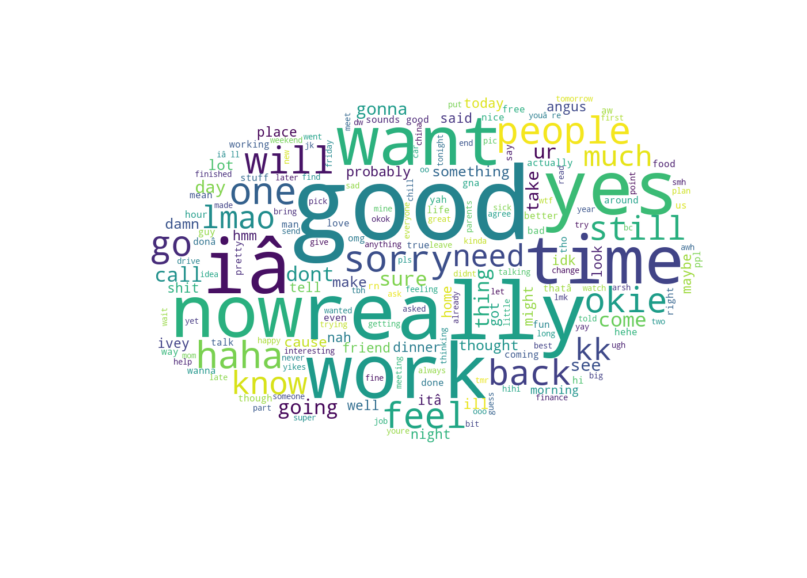

In [10]:
# showing the wordcloud in a plot
plt.figure(figsize=(20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

Interesting! Individual words don't really mean anything but can serve as a proxy to prevalent topics we talk about. We seem to talk about work a lot, which makes sense considering we started talking in the summer when we were both working. "Time" also makes a lot of sense as we frequently ask each other what time we're getting off work or end class. "Good" and "really" can really stem from anything, maybe looking at bigrams later on will help?

Let's look at the wordcloud for one of my buddies and see how that fares.

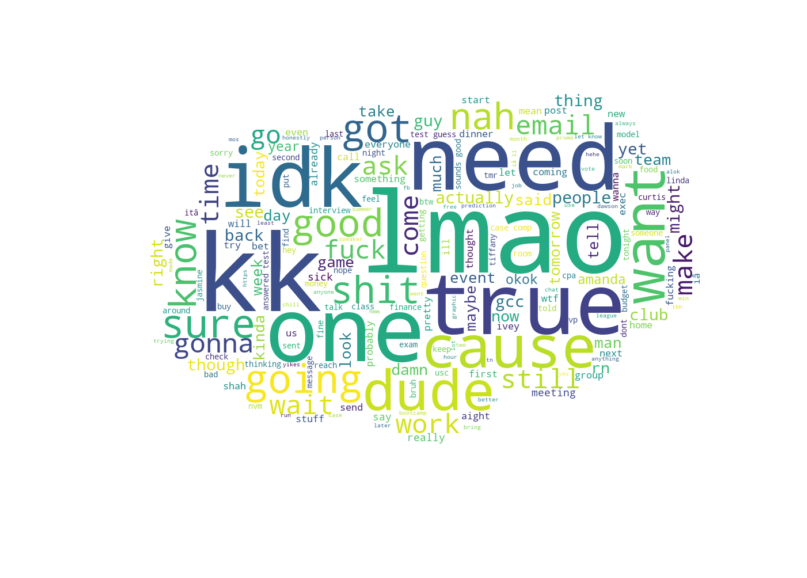

In [11]:
# what does my wordcloud with a friend look like?
comparison_text = get_message('AngusLai')
comparison_text_wordcloud = ""

# iterate over each json and extraxt all content into one string
for text in comparison_text:
    comparison_text_wordcloud = comparison_text_wordcloud + format_message(text).lower()
cloud = create_wordcloud(comparison_text_wordcloud)

# showing the wordcloud in a plot
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()

Seems to have many more acronyms and short forms, which makes sense as we're a lot more casual with each other than I am with my girlfriend. I distinctly remember "Dude", "idk", and "lmao" as a major part of our daily lexicon. There's also more big words in this wordcloud, mostly has to do with me and my friend being very short and concise with each other. I guess this means more varied, flowery language is used when me and my girlfriend talk!

## Time Series Plots

I was interesting in seeing our different patterns of communication in terms of number of messages over time. Using matplotlib I plotted some interesting graphs.

In [12]:
# iterate over each json, converting it to a dataframe
main_text_list = []
for text in main_text:
    text = pd.DataFrame.from_dict(text['messages'])
    main_text_list.append(text)

In [13]:
# merge into on dataframe
main_text_df = pd.concat(main_text_list, sort = False)

# grabbing the timestamp, sender, content, and type
main_text_df = main_text_df[['sender_name', 'timestamp_ms', 'content', 'type']]

# converting timestamp to datetime
main_text_df_ts = date_conversion(main_text_df)
main_text_df_ts.head()

,sender_name,timestamp_ms,content,type
0,Alysaa Coco,2019-12-19 18:41:55,Sorry that was long,Generic
1,Alysaa Coco,2019-12-19 18:41:52,But I could easily cut Vietnam if need be,Generic
2,Alysaa Coco,2019-12-19 18:41:41,Cause i havenât been to those,Generic
3,Alysaa Coco,2019-12-19 18:41:33,"I think my top places are Bali, parts of Thail...",Generic
4,Alysaa Coco,2019-12-19 18:41:19,And I go back to HK so often that Iâll alway...,Generic


### How many messages have we sent each other?

In [14]:
# how many total messages did we send to each other?
total_msgs = len(main_text_df_ts)
print(total_msgs)

20997


Wow! A whopping 20,000 messages! Not sure whether that's a lot or not, but I text my parents a max of 5 times per week, so that says a lot about how much I like to keep in regular contact with people in my life.

### Who sends more messages?

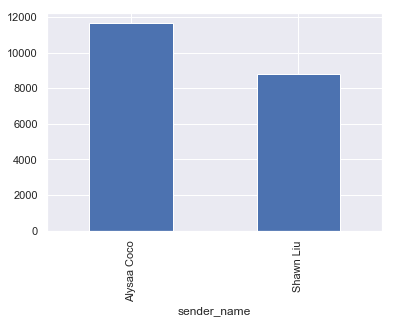

In [15]:
# who sent more messages?
sns.set()
main_text_df_ts.groupby('sender_name')['content'].count().plot(kind = 'bar')

Apparently I need to step up my messaging game, my girlfriend is almost 3000 messages ahead of me! I guess I'm more a short messager??

### Messaging pattern over time

It'd be interesting to see how frequently we messaged over the course of us knowing each other, from when we first met to when we started dating to the present day.

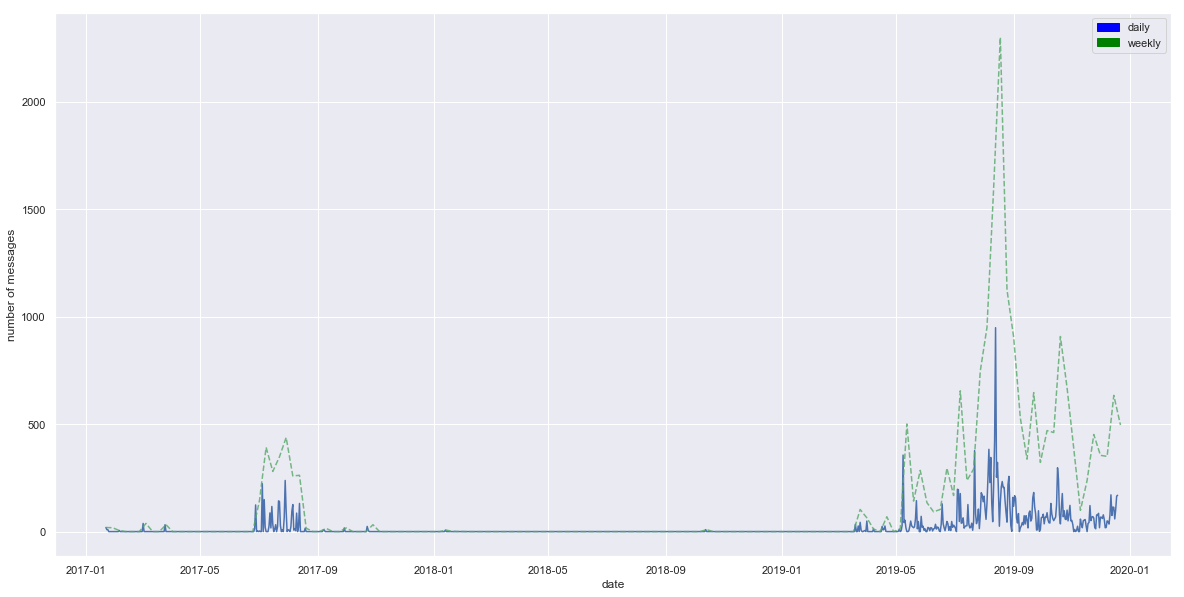

In [16]:
# grouping by day and week
messages_day = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'D')).count()
messages_week = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()

# plotting daily and weekly messages
plt.figure(figsize=(20,10))
plt.plot(messages_day['content'], color = 'b', alpha = 1)
plt.plot(messages_week['content'], color = 'g', alpha = 0.8, linestyle = '--')
plt.xlabel('date')
plt.ylabel('number of messages')
legend_daily = mpatches.Patch(color = 'blue', label = 'daily')
legend_weekly = mpatches.Patch(color = 'green', label = 'weekly')
plt.legend(handles=[legend_daily, legend_weekly])

plt.show()

Wow! It's cool to see the entire message history mapped out over the last 2 years. At the very beginning we barely talked because we just met and weren't that close, followed by that summer when we both worked at the same company. That is followed by a 1.5 year gap with almost no messages. This gap is due to the fact that she had started her own business and therefore had little time to message her friends.

In early-mid April we started chatting again after she stopped working on her business. This was followed by an increasing amount of messages as we started becoming more "interested" in each other. The cause of the huge spike in early-august is a lengthy conversation after dinner. Weekly messages went down as we started seeing each in-person at school in the fall and back up again when she left to go on vacation in San Francisco. The exam period then started, resulting in less messages overall and was quickly ended when she left for Europe for a month around early December.

### Again, who consistently sends more messages?

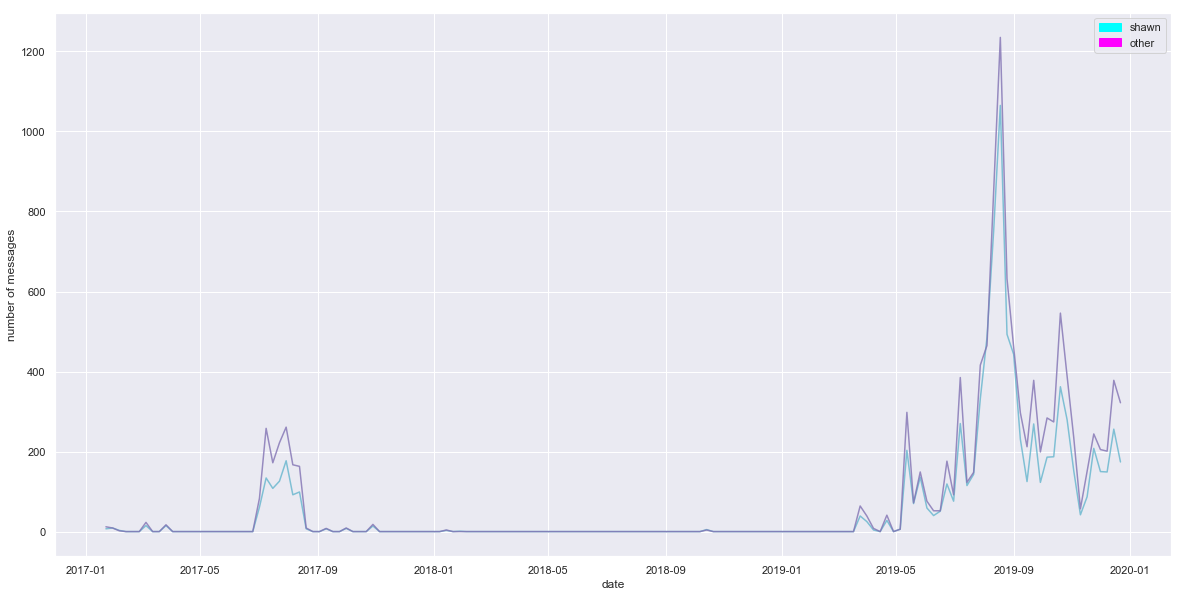

In [17]:
# splitting up weekly messages by sender name
messages_day_shawn = main_text_df_ts[main_text_df_ts['sender_name'] == 'Shawn Liu']\
.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()
messages_day_other = main_text_df_ts[main_text_df_ts['sender_name'] != 'Shawn Liu']\
.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W')).count()

# plotting weekly messages by sender
plt.figure(figsize=(20,10))
plt.plot(messages_day_shawn['content'], color = 'c', alpha = 0.8)
plt.plot(messages_day_other['content'], color = 'm', alpha = 0.8)
plt.xlabel('date')
plt.ylabel('number of messages')
legend_shawn = mpatches.Patch(color = 'cyan', label = 'shawn')
legend_other = mpatches.Patch(color = 'magenta', label = 'other')
plt.legend(handles=[legend_shawn, legend_other])

plt.show()

It seems as though I am, as previously mentioned, more concise and to-the-point, even after we started dating!

### What about on specific weekdays?

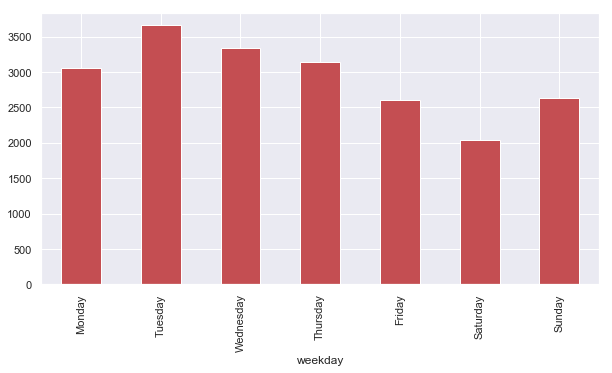

In [18]:
# dictionary and list of weekdays to map onto df and sort
weekdays_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekdays_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# creating a weekday column with dt.dayoftheweek, then mapping to names of weekdays for clarity
main_text_df_ts['weekday'] = main_text_df_ts['timestamp_ms'].dt.dayofweek
main_text_df_ts['weekday'] = main_text_df_ts['weekday'].map(weekdays_dict)

# sorting by weekdays to maintain the order to days in the plot
main_text_df_ts['weekday'] = pd.Categorical(main_text_df_ts['weekday'], categories = weekdays_list, ordered = True)
main_text_df_ts = main_text_df_ts.sort_values('weekday')

# weekday plots
main_text_df_ts.groupby('weekday')['content'].count().plot(kind = 'bar',figsize = (10,5), color = 'r')

Odd that Tuesday is the day of the week with the most messages sent. It was probably because that's when we started to miss each other the most (we always hung out on the weekends). It also makes sense that Friday and Saturday had the least messages as we were most likely spending time in-person.

### Specific times of the day?

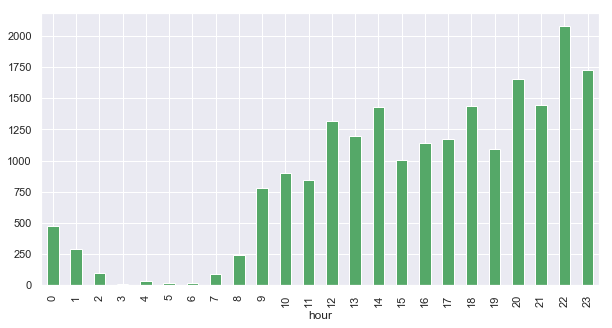

In [19]:
# creating a hour column with dt.hour, then sorting
main_text_df_ts['hour'] = main_text_df_ts['timestamp_ms'].dt.hour
main_text_df_ts = main_text_df_ts.sort_values('hour')

# hourly plot
main_text_df_ts.groupby('hour')['content'].count().plot(kind = 'bar', figsize = (10,5), color = 'g')

Seems fairly typical. The days when we're apart from each other tends to result in late-night conversations. 

## Sentiment Analysis

Using the pre-trained VADER model from NLTK I did a sentiment analysis on each message we sent each other. The higher the score, the more positive the messages. 

Positivity could be associated with words such as "love", "nice", "good", "great", while negativity is tied to words such as "hurt", "ugly", "sad", "bad", "worse". From my understanding, the VADER model can also detect the instensity of the emotion with the use of capitalization ("GOOD" is more positive than "good"), punctuation ("GOOD!!!" is way more positive than "good..."), degree modifiers ("EXTREMELY GOOD!!!" more positive than "a little good"). VADER can also detect the use of conjunctions to change the polarity of a message ("food here was good *but* the service is horrible") and can decode the meaning of certian emojis. 

Seeing as our chat is full of emojis, VADER should do a good job of detecting some nuances in social media conversations that couldn't have been capture otherwise. So all in all this should be fun!

In [20]:
# re-sorting by timestamp and reindexing 
main_text_df_ts.sort_values('timestamp_ms', ascending = False, inplace = True)
main_text_df_ts = main_text_df_ts.reset_index(drop=True)

# dropping nan values, which occur because of there being a pic/video instead of text
main_text_df_ts.dropna(inplace = True)

In [21]:
# execute normalization function to get ready for sentiment analysis
cleaned_content = cleaner(main_text_df_ts)

# extracting compound scores
sentiment_compound = []
sentiment = sentiment_analyzer(cleaned_content)
for score in sentiment:
    sentiment_compound.append(score['compound'])

In [22]:
# adding cleaned text and sentiment scores to dataframe
main_text_df_ts['content'] = cleaned_content
main_text_df_ts['sentiment_score'] = sentiment_compound

main_text_df_ts.head()

,sender_name,timestamp_ms,content,type,weekday,hour,sentiment_score
0,Alysaa Coco,2019-12-19 18:41:55,Sorry that was long,Generic,Thursday,18,-0.0772
1,Alysaa Coco,2019-12-19 18:41:52,But I could easily cut Vietnam if need be,Generic,Thursday,18,0.0772
2,Alysaa Coco,2019-12-19 18:41:41,Cause i haven't been to those,Generic,Thursday,18,0.0000
3,Alysaa Coco,2019-12-19 18:41:33,"I think my top places are Bali, parts of Thail...",Generic,Thursday,18,0.2023
4,Alysaa Coco,2019-12-19 18:41:19,And I go back to HK so often that I'll always ...,Generic,Thursday,18,0.4767


### What's the overall sentiment these past couple of years?

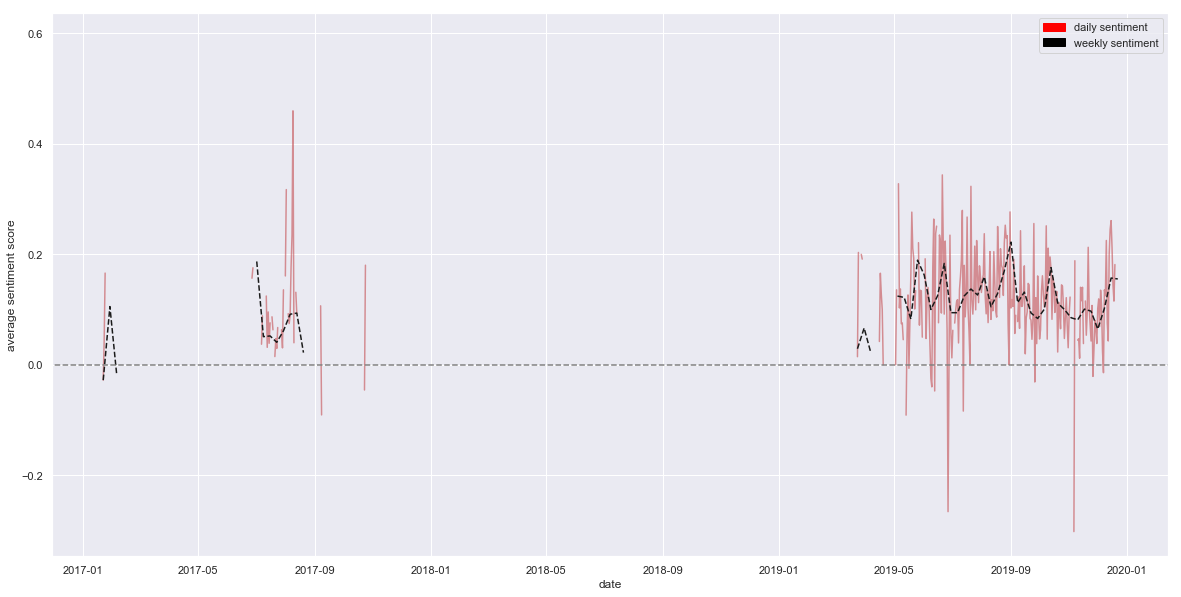

In [23]:
# plotting daily and weekly sentiment scores
sentiment_day = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'D'))['sentiment_score'].mean()
sentiment_week = main_text_df_ts.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W'))['sentiment_score'].mean()

# plotting daily and weekly messages
plt.figure(figsize=(20,10))
plt.plot(sentiment_day, color = 'r', alpha = 0.6)
plt.plot(sentiment_week, color = 'k', alpha = 1, linestyle = '--')
plt.axhline(y = 0.0, xmin = -1, xmax = 1,color = 'gray',linestyle = '--')
plt.xlabel('date')
plt.ylabel('average sentiment score')
legend_daily = mpatches.Patch(color = 'red', label = 'daily sentiment')
legend_weekly = mpatches.Patch(color = 'black', label = 'weekly sentiment')
plt.legend(handles=[legend_daily, legend_weekly])

plt.show()

Cool to see the average weekly sentiment increase as we start talking and dating! Unfortunately no sentiment data in the middle as little to no messages were sent during that period of our Facebook friendship.

### Who has a higher sentiment score on average?

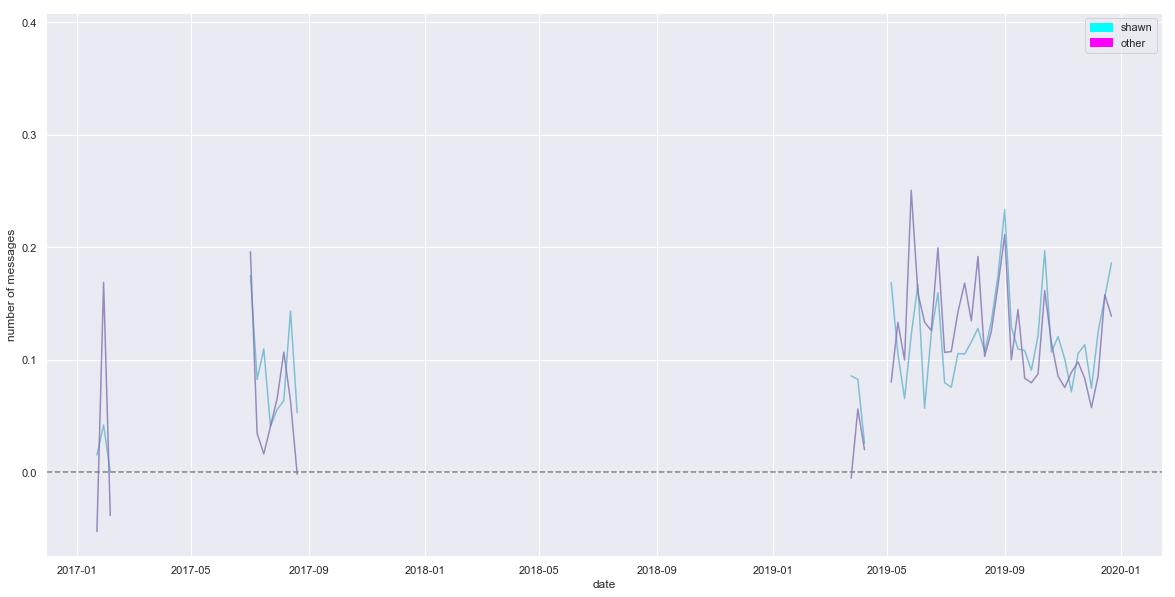

In [24]:
# splitting up each person's sentiment scores
shawn_sentiment = main_text_df_ts[main_text_df_ts['sender_name'] == 'Shawn Liu']
shawn_sentiment = shawn_sentiment.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W'))['sentiment_score'].mean()

other_sentiment = main_text_df_ts[main_text_df_ts['sender_name'] != 'Shawn Liu']
other_sentiment = other_sentiment.groupby(pd.Grouper(key = 'timestamp_ms', freq = 'W'))['sentiment_score'].mean()

# plotting weekly messages by sender
plt.figure(figsize=(20,10))
plt.plot(shawn_sentiment, color = 'c', alpha = 0.8)
plt.plot(other_sentiment, color = 'm', alpha = 0.8)
plt.axhline(y = 0.0, xmin = -1, xmax = 1,color = 'gray',linestyle = '--')
plt.xlabel('date')
plt.ylabel('number of messages')
legend_shawn = mpatches.Patch(color = 'cyan', label = 'shawn')
legend_other = mpatches.Patch(color = 'magenta', label = 'other')
plt.legend(handles=[legend_shawn, legend_other])

plt.show()

This is so funny! My sentiment is lower than hers until we started dating in early August. Since then, mine increased to always be slightly higher. Maybe she chased harder in the beginning after all?

## Named Entities

Are there any particular topics we like talking about the most?

In [25]:
# gathering a list of tokens, position tags, and named entities from all messages --TAKE A WHILE TO RUN
entities = cleaner(main_text_df_ts, lemm = True)